In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
def filter_swap_pairs(df_filepaths: str, token_0: str, token_0_decimal: int, token_1: str, token_1_decimal: int) -> pl.DataFrame:
    '''
    Filter data for a specific swap pair of tokens
    '''

    # scan for token 0 -> token 1 swap
    q_in = (
        pl.scan_parquet(df_filepaths)
        .filter((pl.col("tokenIn_symbol") == token_0) & (pl.col("tokenOut_symbol") == token_1))
    )

    # convert query into df
    df_in = q_in.collect()

    # apply decimal converesion
    df_in = df_in.with_columns(
        amountIn= pl.col("amountIn") / 10 ** token_0_decimal,
        amountOut= pl.col("amountOut") / 10 ** token_1_decimal
    )

    # calculate execution price
    df_in = df_in.with_columns(
        executionPrice= pl.col("amountOut") / pl.col("amountIn")
    )

    # scan for token 1 -> token 0 swap
    q_out = (
        pl.scan_parquet(df_filepaths)
        .filter((pl.col("tokenIn_symbol") == token_1) & (pl.col("tokenOut_symbol") == token_0))
    )

    # convert query into df
    df_out = q_out.collect()
    
    # apply decimal converesion
    df_out = df_out.with_columns(
        amountIn= pl.col("amountIn") / 10 ** token_1_decimal,
        amountOut= pl.col("amountOut") / 10 ** token_0_decimal
    )

    # calculate execution price
    df_out = df_out.with_columns(
        executionPrice= pl.col("amountIn") / pl.col("amountOut")
    )

    # concat dfs
    return pl.concat([df_in, df_out])

In [4]:
swap_df_usdc = filter_swap_pairs(df_filepaths, 'WETH', 18, 'USDC', 6)
swap_df_usdt = filter_swap_pairs(df_filepaths, 'WETH', 18, 'USDT', 6)
# binance has pegged tokens and they both have 18 decimals
swap_df_eth = filter_swap_pairs(df_filepaths, 'ETH', 18, 'USDC', 18)

In [5]:
swap_df = pl.concat([swap_df_usdc, swap_df_usdt, swap_df_eth])

In [6]:
swap_df.shape

(6689345, 14)

In [7]:
# filter out outlier values that are too large or too small. We get weird values probably due rounding error using floats
filter_swap_df = swap_df.filter((pl.col("executionPrice") < 2500) & (pl.col("executionPrice") > 1000))

# second filter for transactions larger than $1 USD
filter_swap_df = filter_swap_df.filter((pl.col("amountInUSD") > 1) & (pl.col("amountOutUSD") > 1))

In [8]:
filter_swap_df.shape

(6431715, 14)

### Plotting

In [9]:
swap_df_pandas = filter_swap_df.to_pandas()

In [10]:
# apply smoothing to the data grouped by blockchain
swap_df_pandas['executionPrice'] = swap_df_pandas.groupby('blockchain')['executionPrice'].transform(lambda x: x.rolling(10, 1).mean())

In [11]:
swap_df_pandas.shape

(6431715, 14)

In [12]:
# print unique groupby values in swap_df_pandas
swap_df_pandas['blockchain'].unique()

array(['arbitrum', 'ethereum', 'optimism', 'polygon', 'bsc'], dtype=object)

In [13]:
# get max execution price
swap_df_pandas['executionPrice'].min()

1350.4268548596872

In [15]:
# reset index
swap_df_pandas = swap_df_pandas.reset_index()

In [16]:
# pivot blockchain column to column headers. Make token the index
pivot_df = swap_df_pandas.pivot(index='blockchain', columns='timestamp', values='executionPrice')

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

KeyError: 'ethereum'

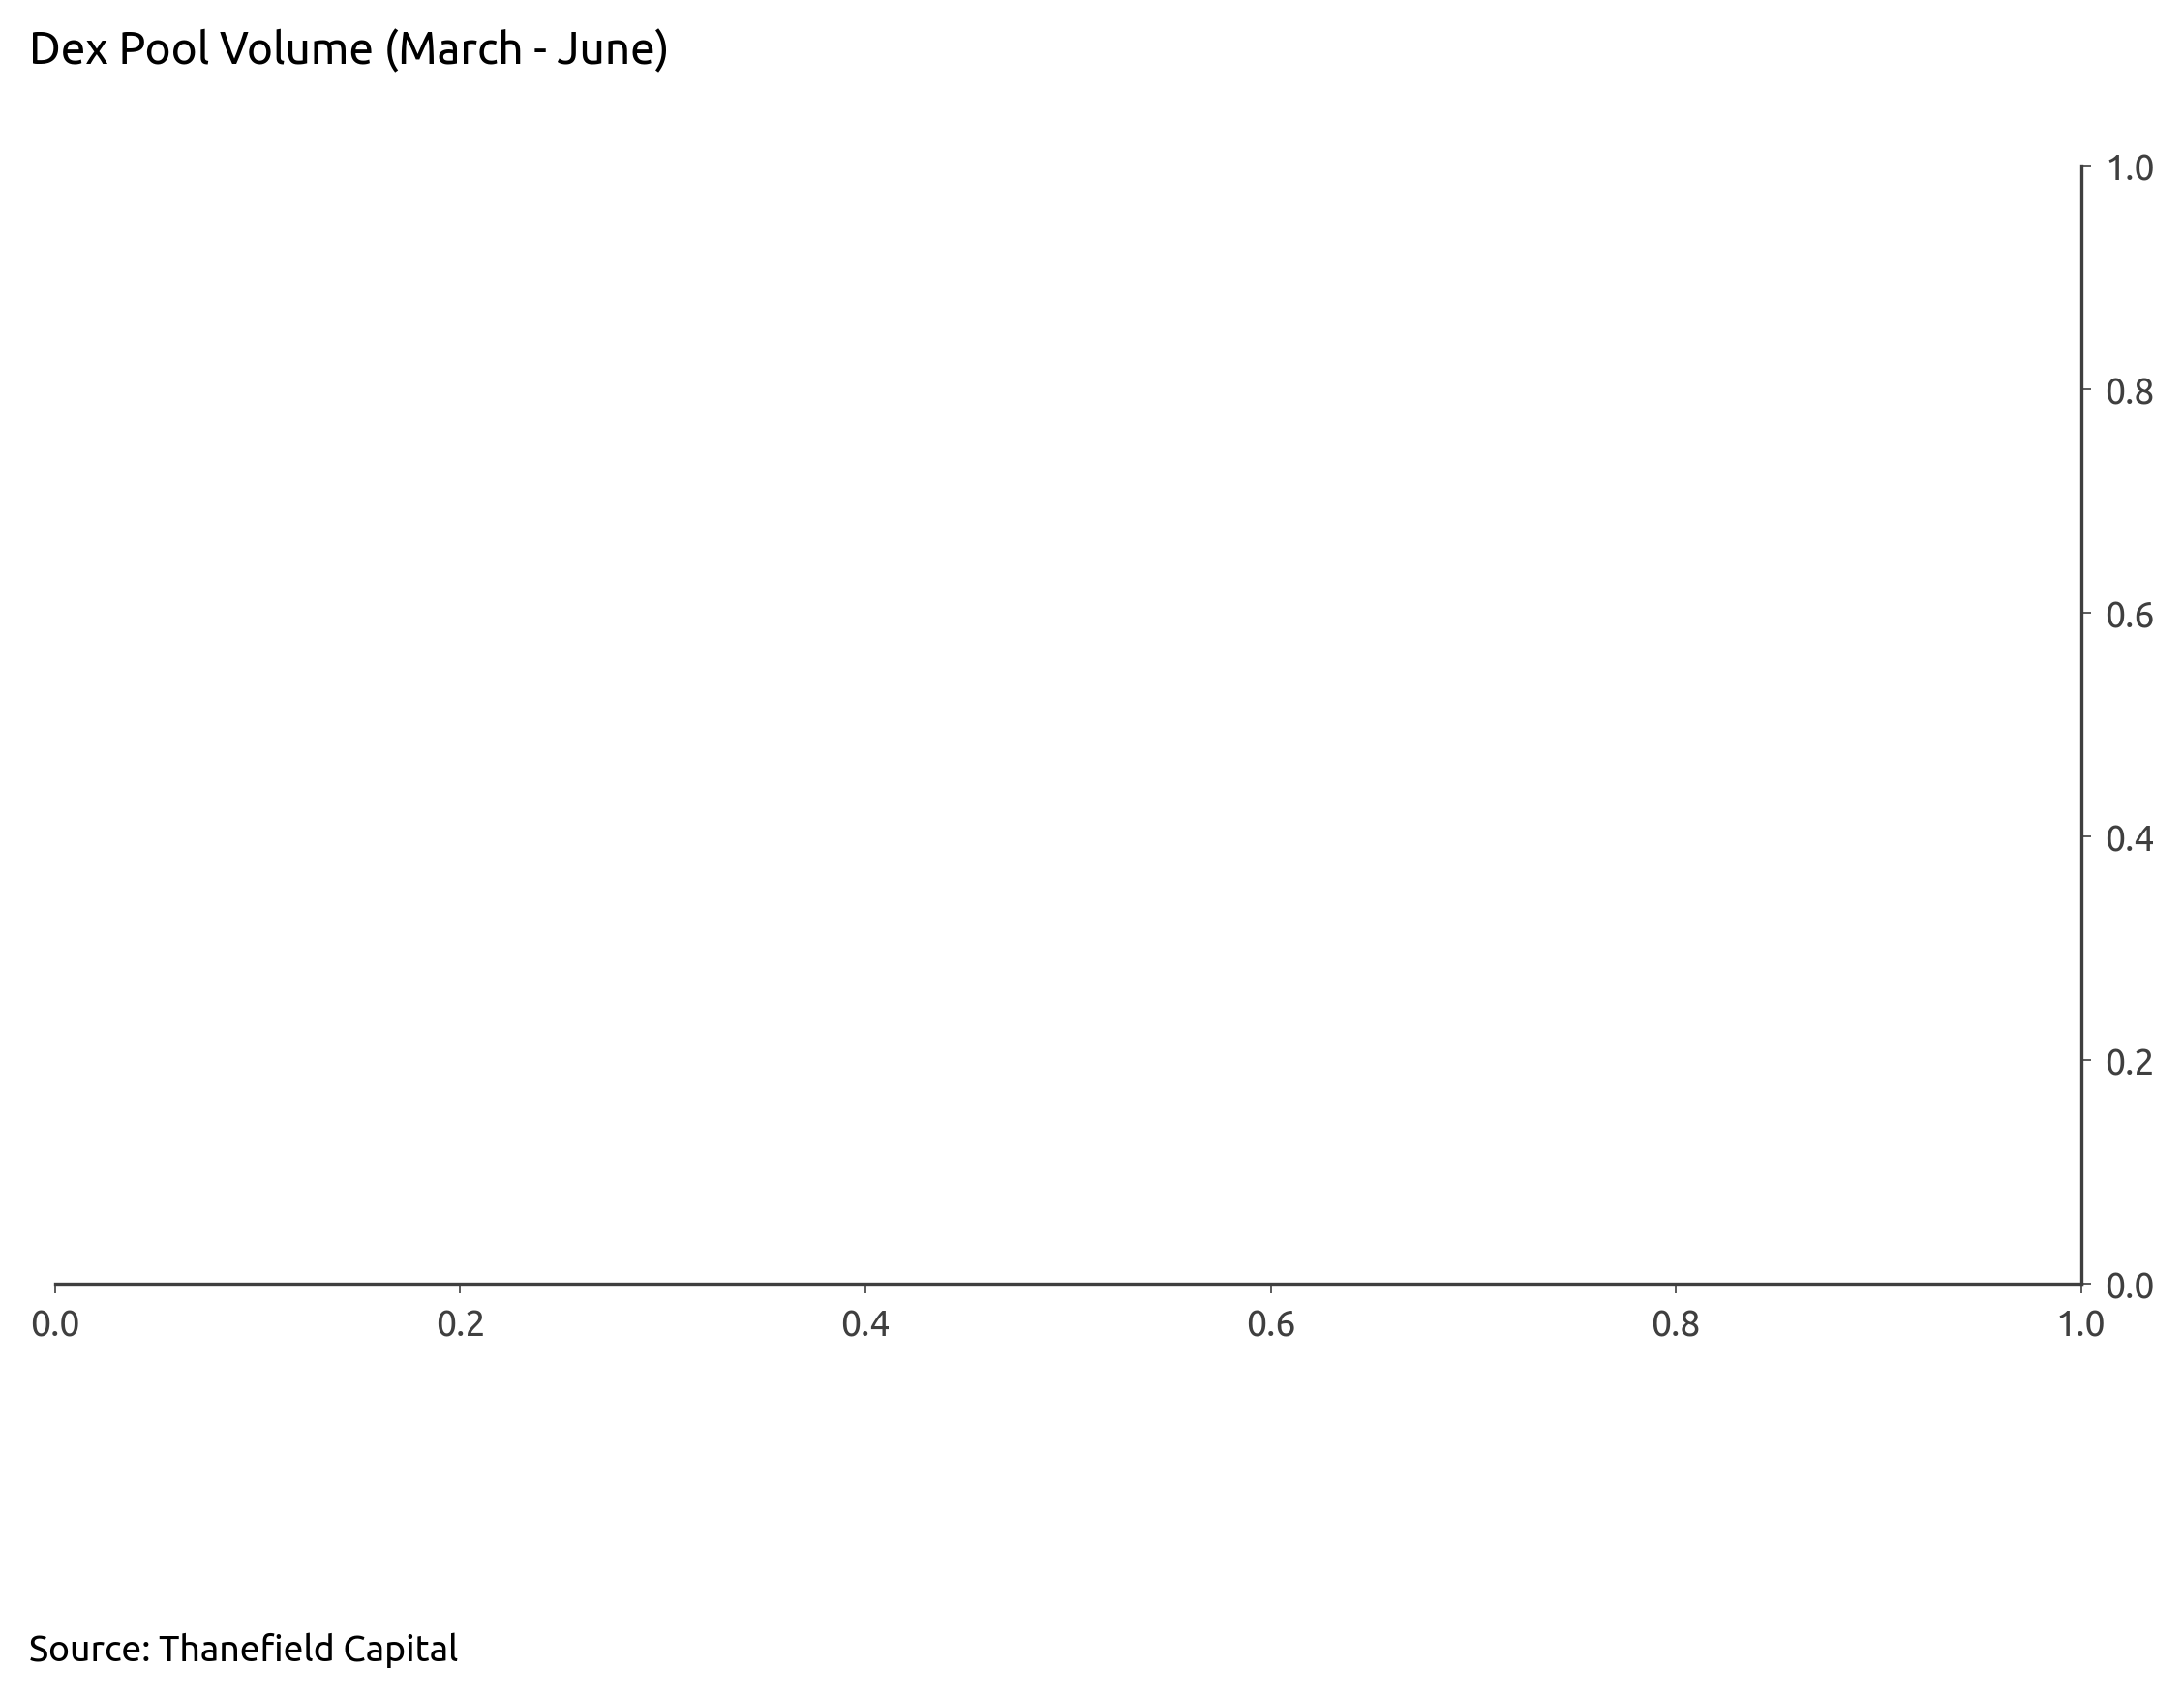

In [ ]:
# note each token has over 1b volume
fig, ax = tc.chart('Dex Pool Volume (March - June)', dates=False)

ax.bar(swap_df_pandas['timestamp'], swap_df_pandas['ethereum']['executionPrice'], color='darkblue', label='ethereum')
ax.bar(swap_df_pandas['timestamp'], swap_df_pandas['arbitrum']['executionPrice'], color='lightblue', label='arbitrum')
ax.bar(swap_df_pandas['timestamp'], swap_df_pandas['bsc']['executionPrice'], color='darkgreen', label='bsc')
ax.bar(swap_df_pandas['timestamp'], swap_df_pandas['optimism']['executionPrice'], color='lightgreen', label='optimism')
ax.bar(swap_df_pandas['timestamp'], swap_df_pandas['polygon']['executionPrice'], color='darkred', label='polygon')

# Apply the custom formatting function to the y-axis
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')

# save chart
tc.save('charts/dex_total_pool_vol.png')

blockchain
arbitrum    Axes(0.125,0.2;0.775x0.68)
ethereum    Axes(0.125,0.2;0.775x0.68)
optimism    Axes(0.125,0.2;0.775x0.68)
polygon     Axes(0.125,0.2;0.775x0.68)
dtype: object

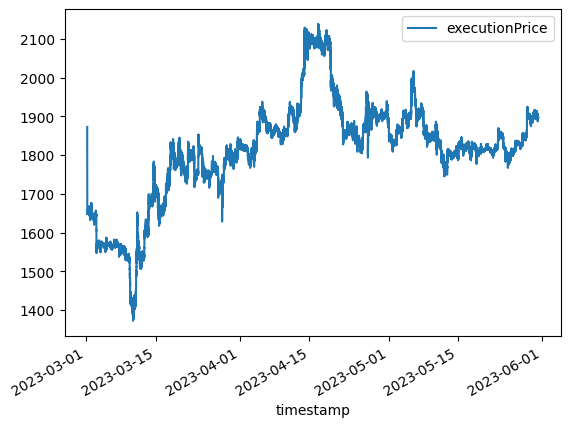

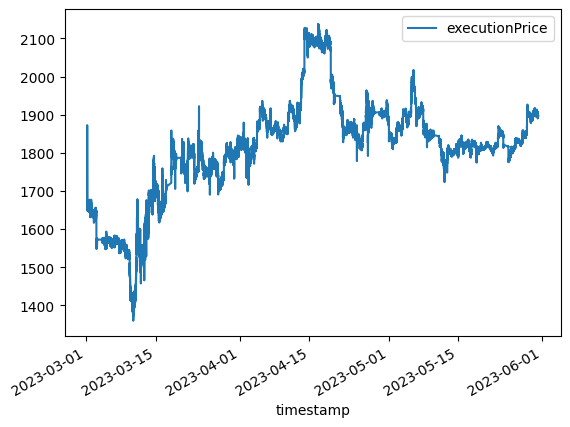

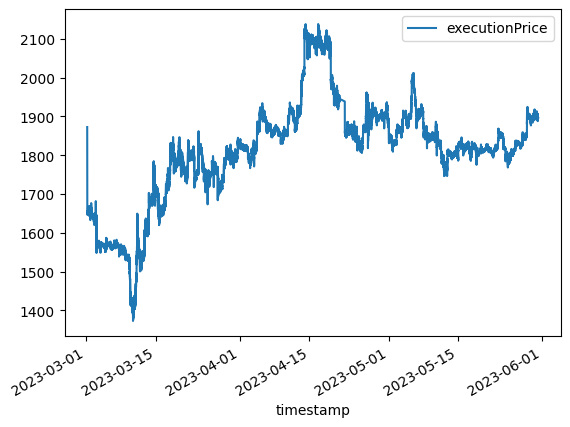

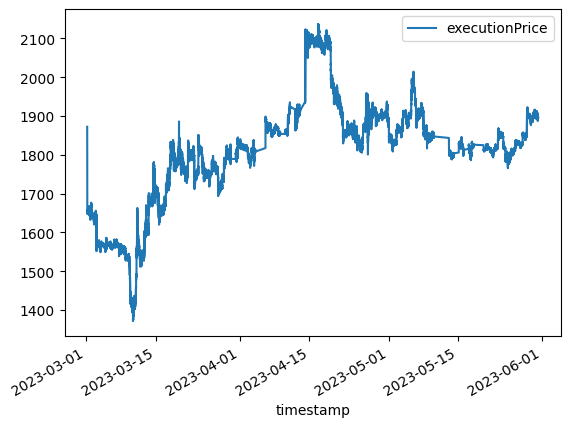

In [ ]:
# plot executionPrice grouped by blockchain on a line plot time series on a single chart
swap_df_pandas.groupby(['blockchain']).plot(x='timestamp', y='executionPrice', kind='line')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

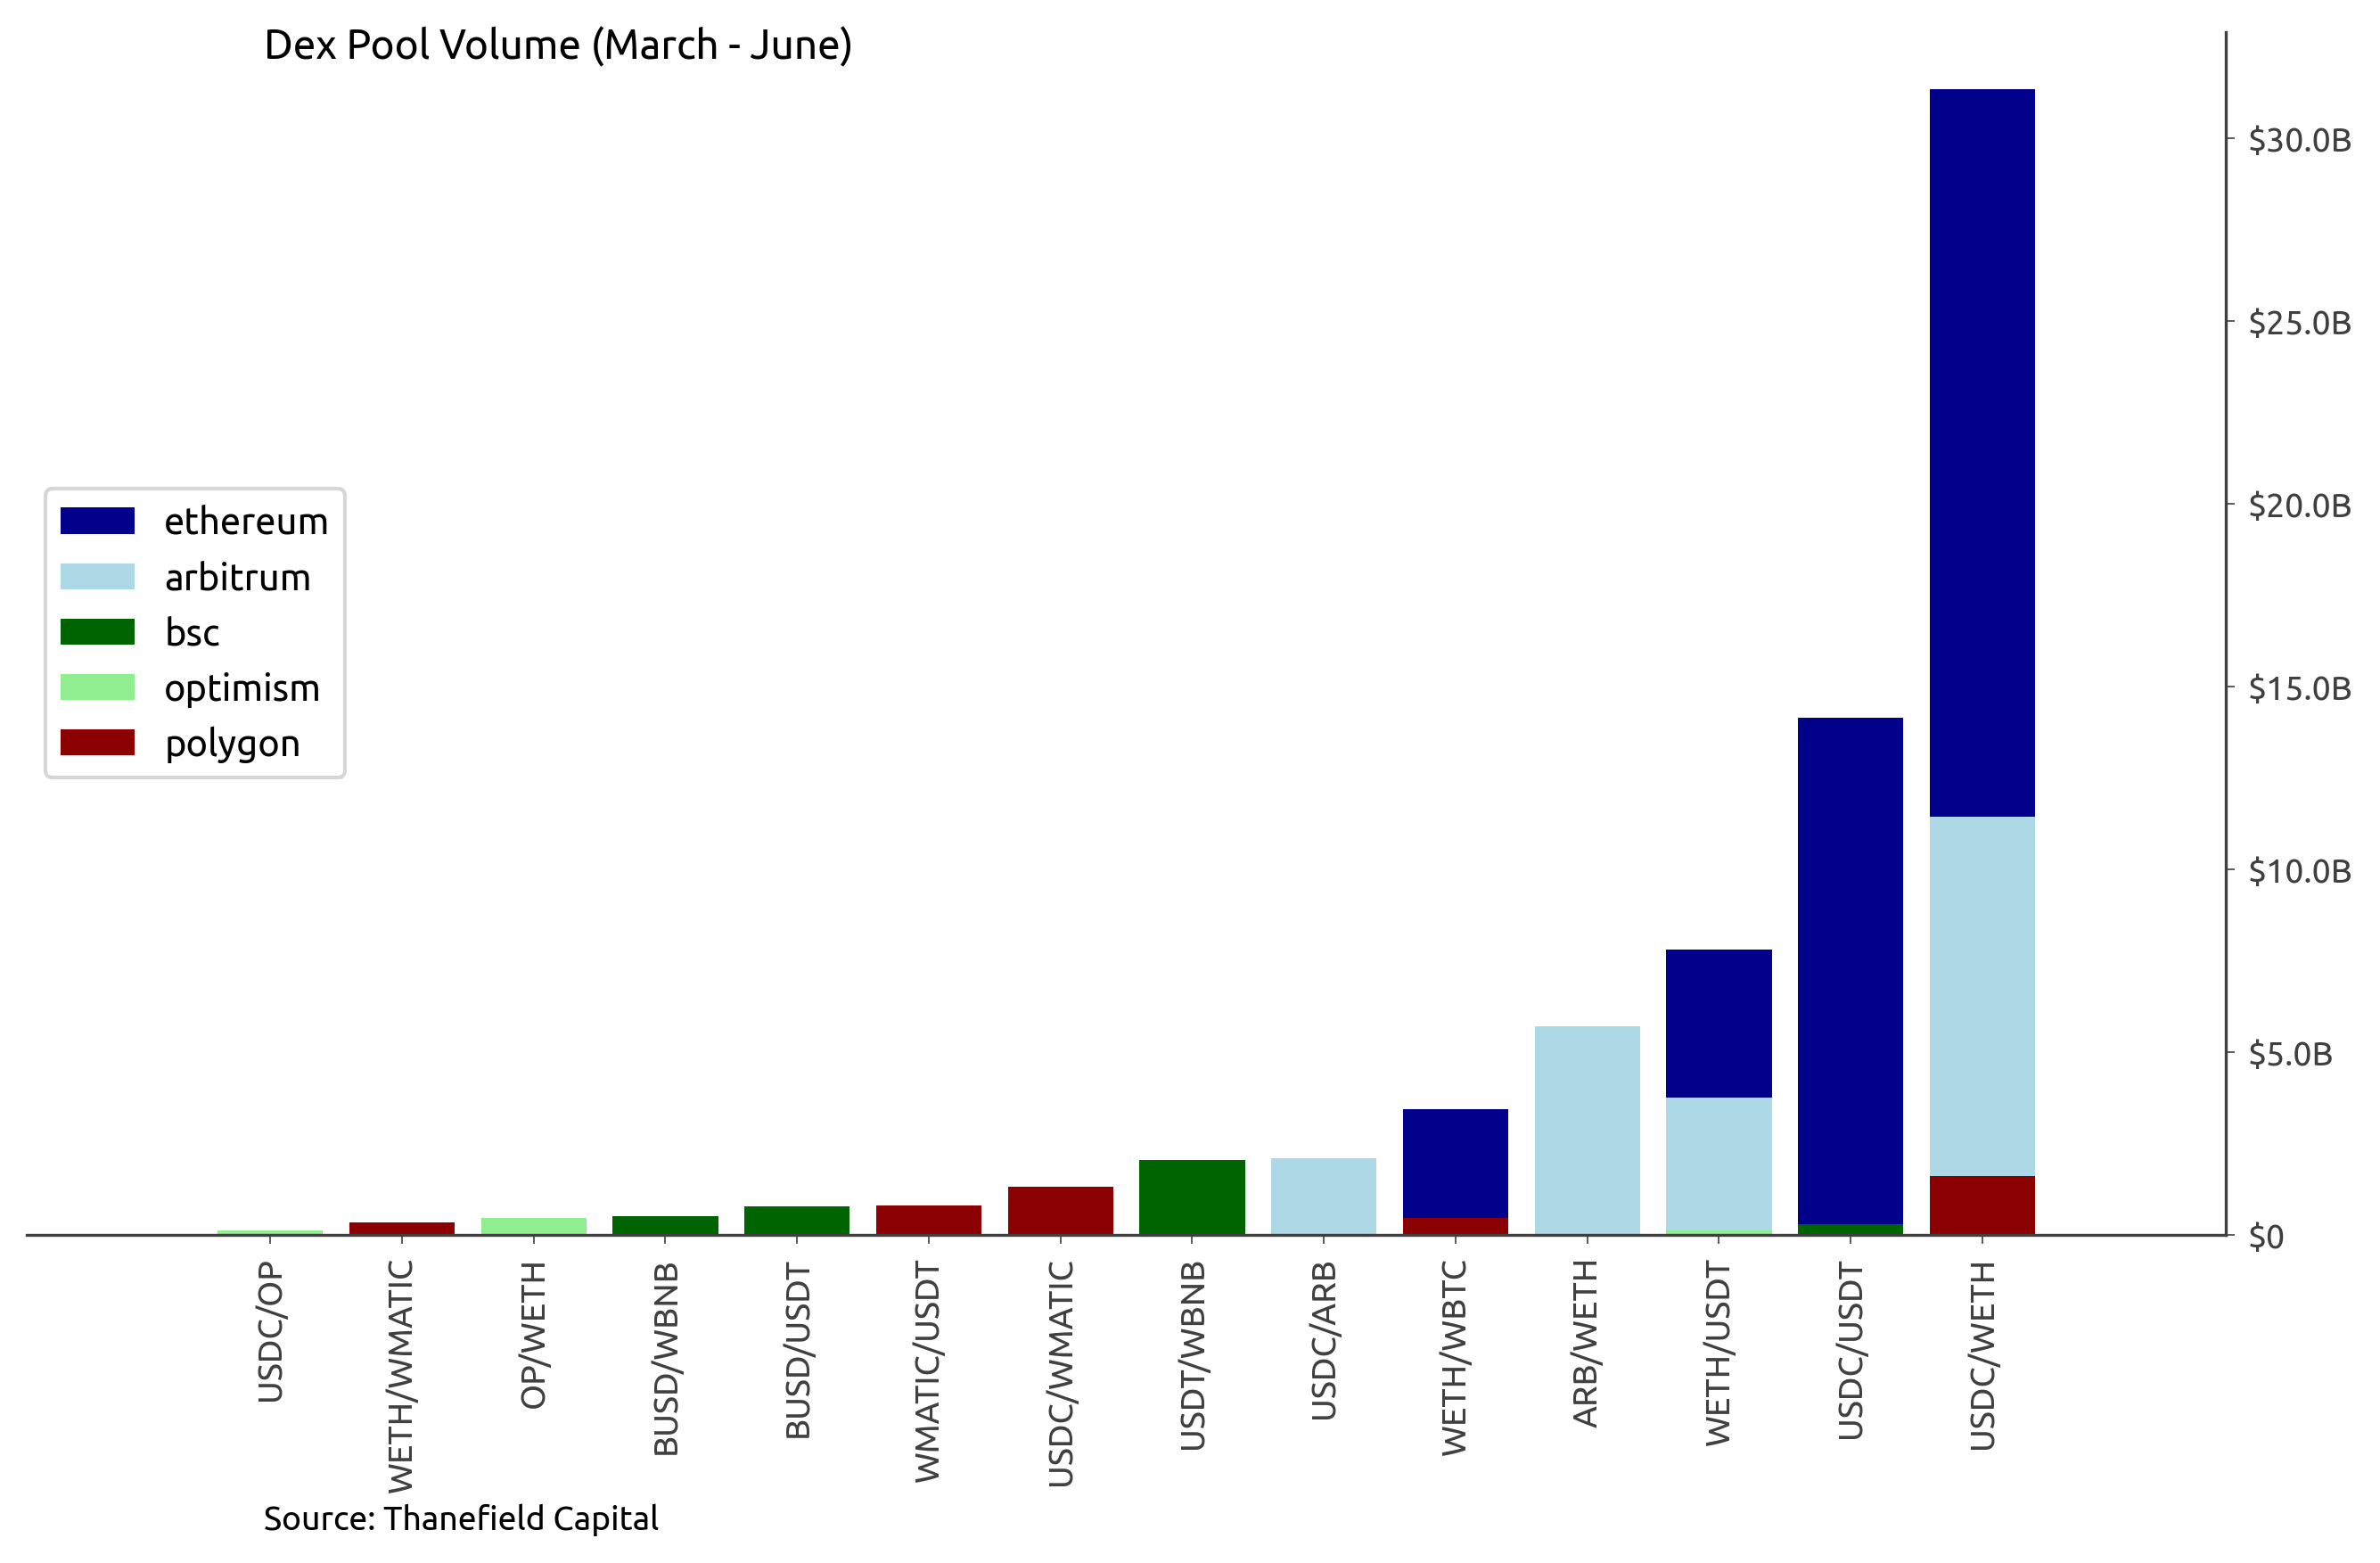

In [ ]:
# note each token has over 1b volume
fig, ax = tc.chart('Dex Pool Volume (March - June)', dates=False)

ax.bar(pivot_df.index, pivot_df['ethereum'], color='darkblue', label='ethereum')
ax.bar(pivot_df.index, pivot_df['arbitrum'], color='lightblue', label='arbitrum')
ax.bar(pivot_df.index, pivot_df['bsc'], color='darkgreen', label='bsc')
ax.bar(pivot_df.index, pivot_df['optimism'], color='lightgreen', label='optimism')
ax.bar(pivot_df.index, pivot_df['polygon'], color='darkred', label='polygon')

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')

# save chart
tc.save('charts/dex_total_pool_vol.png')